In [2]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
img = 'testimg-mask-2.jpg'

results = model(img)
results.print()

Using cache found in /Users/ayaan/.cache/torch/hub/ultralytics_yolov5_master
WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View settings with 'yolo settings' or at '/Users/ayaan/Library/Application Support/Ultralytics/settings.yaml'
Update settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'.
WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

YOLOv5 🚀 2023-7-8 Python-3.10.5 torch-

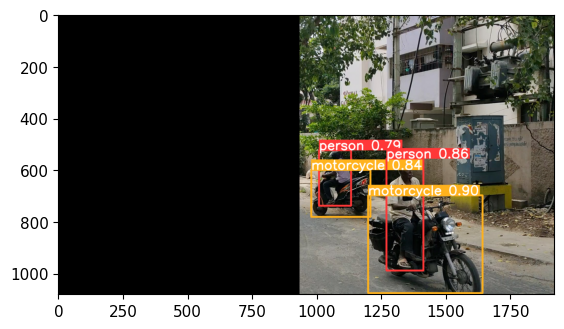

In [3]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()

In [4]:
a = results.xyxy[0].cpu().numpy()
a

array([[     1200.3,      699.52,      1643.6,      1076.6,     0.90277,           3],
       [     1271.6,      557.18,      1414.5,      989.56,     0.85612,           0],
       [     980.83,      601.71,      1209.8,      782.67,     0.83917,           3],
       [     1010.8,      525.47,      1134.3,       739.8,     0.78671,           0]], dtype=float32)

In [5]:

box1 = [int(a[0][0]),int(a[0][1]),int(a[0][2]),int(a[0][3])]
box2 = [int(a[1][0]),int(a[1][1]),int(a[1][2]),int(a[1][3])]

def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    union_area = (box1[2] - box1[0]) * (box1[3] - box1[1]) + (box2[2] - box2[0]) * (box2[3] - box2[1]) - intersection_area
    iou = intersection_area / union_area
    return iou

calculate_iou(box1, box2)

0.2213894093969047

In [6]:
num_boxes = len(a)
iou_matrix = []
personBike = {}

for i in range(num_boxes):
    iou_row = []
    for j in range(num_boxes):
        iou = calculate_iou(a[i], a[j])
        iou_row.append(iou)
        if int(a[j][5]) == 0 and j not in personBike:
            personBike[j] = [None, 0]
    iou_matrix.append(iou_row)


# Print or use the IoU matrix
for i in range(num_boxes):
    if int(a[i][5]) == 0:
        for j in range(num_boxes):
            if int(a[j][5]) == 3:
                if iou_matrix[i][j] > personBike[i][1] and iou_matrix[i][j] > 0.2:
                    personBike[i] = [j, iou_matrix[i][j]]

personBike

{1: [0, 0.22099762], 3: [2, 0.3353509]}

In [13]:
"""bikecoors = []

for i in personBike:

    if personBike[i][0] is not None:
        print(a[i], a[personBike[i][0]])
        print(a[personBike[i][0]][0])
        bikecoors.append([int(min(a[i][0], a[personBike[i][0]][0])), int(min(a[i][1], a[personBike[i][0]][1])),
                          int(max(a[i][2], a[personBike[i][0]][2])), int(max(a[i][3], a[personBike[i][0]][3]))])


bikecoors"""
coorswithstat = []

for i in hel_ppl:
    if hel_ppl[i][1] is not None:
        print(a[hel_ppl[i][1]])
        print(a[personBike[hel_ppl[i][1]][0]])
        coorswithstat.append([int(min(a[hel_ppl[i][1]][0], a[personBike[hel_ppl[i][1]][0]][0])), int(min(a[hel_ppl[i][1]][1], a[personBike[hel_ppl[i][1]][0]][1])),
                          int(max(a[hel_ppl[i][1]][2], a[personBike[hel_ppl[i][1]][0]][2])), int(max(a[hel_ppl[i][1]][3], a[personBike[hel_ppl[i][1]][0]][3])), hel_ppl[i][0]])

print(coorswithstat)



[     1271.6      557.18      1414.5      989.56     0.85612           0]
[     1200.3      699.52      1643.6      1076.6     0.90277           3]
[     1010.8      525.47      1134.3       739.8     0.78671           0]
[     980.83      601.71      1209.8      782.67     0.83917           3]
[[1200, 557, 1643, 1076, 1], [980, 525, 1209, 782, 0]]


In [8]:
helmodel = torch.hub.load('ultralytics/yolov5', 'custom', path='helmet-best.pt')
helresults = helmodel(img)
helresults.print()

Using cache found in /Users/ayaan/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-8 Python-3.10.5 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
image 1/1: 1080x1920 1 With Helmet, 1 Without Helmet
Speed: 18.4ms pre-process, 63.3ms inference, 0.4ms NMS per image at shape (1, 3, 384, 640)


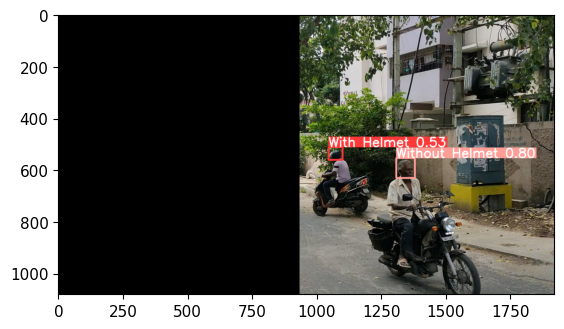

In [14]:
%matplotlib inline
plt.imshow(np.squeeze(helresults.render()))

In [11]:
def calculate_overlap_extent(box1, box2):
    # Calculate intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate the area of the smaller box
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    smaller_area = min(box1_area, box2_area)

    # Calculate overlap extent
    overlap_extent = intersection_area / smaller_area
    return overlap_extent

# Example usage
box_a = [1271.6,557.18,1414.5,989.56]
box_b = [1309.9,555.92,1381.6,632.14]


overlap_extent = calculate_overlap_extent(box_b, box_b)
print("Overlap extent:", overlap_extent)

Overlap extent: 1.0


In [15]:
b = helresults.xyxy[0].cpu().numpy()
print(b)
num_hel_ppl = len(b)
hel_ppl = {}

for i in range(num_hel_ppl):
    if i not in hel_ppl:
        hel_ppl[i] = [int(b[i][5]), None, 0] #helmet status, person id from yolov5s model and the confidence
    for j in range(num_boxes):
        if a[j][5] == 0:
            o = calculate_overlap_extent(b[i], a[j])
            if o > hel_ppl[i][2]:
                hel_ppl[i][1], hel_ppl[i][2] = int(j), o

print(hel_ppl)

[[     1309.9      555.92      1381.6      632.14     0.79978           1]
 [     1047.1       513.2      1101.4      562.24      0.5293           0]]
{0: [1, 1, 0.9834318], 1: [0, 3, 0.74984974]}


These are the coordinates of the bounding boxes of all the bikes in the frame, with their helmet status and the extent of overlap.